<a href="https://colab.research.google.com/github/riccardotomada/Airfoil-Analysis/blob/master/Advection%20DIffusion%20equation/ROM%20linear/POD_utilities_and_datasets_AD_pynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Installing FEnICS
%%capture
try:
    import dolfin
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenics-install.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"
    import dolfin 

In [3]:
# Importing the libraries needed
from fenics import *
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import numpy as np
from scipy.stats import qmc
import csv
from sklearn.decomposition import PCA

In [4]:
# FOM construction

# Generating the mesh
nx, ny = 50, 50
mesh = UnitSquareMesh(nx, ny)
dim = mesh.geometric_dimension()
print(dim)
mesh.coordinates().shape

2


(2601, 2)

In [5]:
# Setting up the measures
dx = Measure('dx', domain=mesh)

In [6]:
# Definition of finite element space
degree = 2
V = FunctionSpace(mesh, 'CG', degree)

Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_6ab56968c6ffa883272fd990bd40fad8bf858cca

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00576591 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.403133 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representation
INFO:FFC:----------------------------

In [7]:
# Data of the problem
bx, by = np.cos(np.pi/4.0), np.cos(np.pi/4.0)
b = Constant((bx, by))
f = Constant(0)

In [8]:
# Generating the sampling grid to retrieve the SNapshots 

x_min, x_max = 0, 1
y_min, y_max = 0, 1
grid_dim = 96

x = np.linspace(x_min, x_max, grid_dim)
y = np.linspace(y_min, y_max, grid_dim)

X = np.zeros((len(x)*len(y), 2))
xs = np.vstack((x,)*len(y)).reshape(-1)
ys = np.vstack((y,)*len(x)).T.reshape(-1)
X[:, 0] = xs
X[:, 1] = ys

In [9]:
# Definition of Dirichlet boundary conditions
gD0 = Constant(0.0)
gD1 = Constant(1.0)

In [10]:
num_samples     = 80
truncated_modes = 16

import random
random.seed(123)

def rnd():
    exp = random.randint(-5, 1)
    significand = 0.9 * random.random() + 0.1
    return significand * 10**exp

parameters_mu = [rnd() for _ in range(num_samples)]

sampler_la    = qmc.LatinHypercube(d = 1, seed = 123)
parameters_la = sampler_la.random(n = num_samples)
parameters_la = np.squeeze(parameters_la, axis = 1)

parameters = np.array([parameters_mu, parameters_la]).T
print(parameters.shape)

Snapshots = np.zeros((10201, parameters.shape[0]))
Snapshot_ae  = np.zeros((grid_dim**2,1))
Snapshots_ae = np.zeros((grid_dim**2, parameters.shape[0]))

for iter in range(parameters.shape[0]):
  mu  = parameters[iter,0]
  la  = parameters[iter,1]
  u = TrialFunction(V)
  v = TestFunction(V)

  def boundary_right(x, on_boundary):
    return on_boundary and np.isclose(x[0], 1.0)

  def boundary_bottom(x, on_boundary):
    return on_boundary and np.isclose(x[1], 0.0)

  def boundary_left_bottom(x, on_boundary):
    return on_boundary and np.isclose(x[0], 0.0) and (x[1] <= la)

  def boundary_left_top(x, on_boundary):
    return on_boundary and np.isclose(x[0], 0.0) and (x[1] >= la)

  def boundary_top(x, on_boundary):
    return on_boundary and np.isclose(x[1], 1.0)

  bc1 = DirichletBC(V, gD0, boundary_right)
  bc2 = DirichletBC(V, gD1, boundary_bottom)
  bc3 = DirichletBC(V, gD1, boundary_left_bottom)
  bc4 = DirichletBC(V, gD0, boundary_left_top)
  bc5 = DirichletBC(V, gD0, boundary_top)

  a0 = (mu * dot(grad(u), grad(v))) * dx
  a1 = (dot(b, grad(u)) * v) * dx
  a  = a0 + a1
  L = f * v * dx

  # ... stabilization term
  h = CellDiameter(mesh)
  bnorm = sqrt(dot(b, b))
  Pe = bnorm*h/(2*mu)
  tau = 0.5*h/bnorm * conditional(Pe/3 > 1, 1, Pe/3)

  # ... streamline diffusion stabilization
  c = tau * dot(b, grad(u)) * dot(b, grad(v)) * dx 
  a_stab = a + c

  # 4. solving discrete problem
  u = Function(V)
  solve(a_stab == L, u, [bc1, bc2, bc3, bc4, bc5])

  Snapshot = np.array(u.vector())
  Snapshots[:, iter] = Snapshot
  for i in range(X.shape[0]):
    Snapshot_ae[i] = u(X[i][0], X[i][1])
  Snapshots_ae[:, iter] = Snapshot_ae[:,0]

Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_6a841430f2429dfe00c82ff00949ce81b7813298

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      1
  Arguments:                 '(v_0)'
  Number of coefficients:    1
  Coefficients:              '[f_6]'
  Unique elements:           'CG2(?,?), R0(?,?), Vector<2 x CG1(?,?)>'
  Unique sub elements:       'CG2(?,?), R0(?,?), Vector<2 x CG1(?,?)>, CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto --> 2
INFO:FFC:  quadrature_degree: 2
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.071543 seconds.

INFO:FFC:Compiler stage 2

(80, 2)


Output streaming troncato alle ultime 5000 righe.
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    1
  Coefficients:              '[f_5]'
  Unique elements:           'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>'
  Unique sub elements:       'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>, R
                             0(?,?), CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto --> 3
INFO:FFC:  quadrature_degree: 3
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.0619004 seconds.

INFO:FFC:Compiler stage 2: Computing interme

In [11]:
# Performing the Singular Value Decomposition on the Snapshots matrix
UU, SS, VV = np.linalg.svd(Snapshots, full_matrices=False)

In [12]:
# Inspecting the Singular Values
my_model = PCA(n_components = 0.999, svd_solver='full')
my_model.fit_transform(Snapshots)

n_modes = my_model.explained_variance_ratio_.cumsum().shape[0]
print("The number of modes required to capture the 99% of the variance is: " + str(n_modes))

The number of modes required to capture the 99% of the variance is: 39


(9216, 80)
(10201, 80)
(10201, 16)


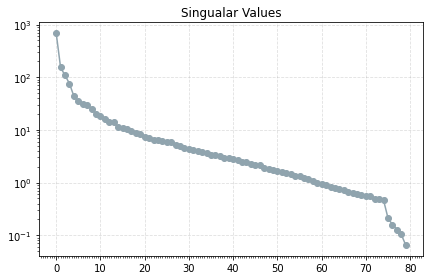

In [13]:
# Plotting the Singular Values
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
plt.plot(SS, marker="o", color = '#90A4AE')
plt.title("Singualar Values")
ax.xaxis.set_minor_locator(MultipleLocator(.5))
ax.yaxis.set_minor_locator(MultipleLocator(.1))
plt.grid(alpha = 0.4, linestyle='--')
fig.tight_layout()
ax.set_yscale('log')

print(Snapshots_ae.shape)
print(UU.shape)

UU = UU[:, :truncated_modes]
print(UU.shape)

In [14]:
# Retrieving the terms of the FOM for the PINN-approach
A = assemble(a_stab)
bc.apply(A)

A1 = assemble(a1)
bc.apply(a1)

b = assemble(L)
bc.apply(b)

#A_array = A.array()
#A_array.shape

# Note: the RHS changes for each parameter
sampler    = qmc.LatinHypercube(d = 1, seed = 48)
res_sample = sampler.random(n = 128)
res_sample = qmc.scale(res_sample, 0.0, 10.0)
B          = np.zeros((101**2, res_sample.size))

for iter in range(res_sample.size):
  mu  = parameters[iter,0]
  f = Expression('100*sin(2*pi*x[0]) * sin(par*pi*x[1])', degree=2, par = par)
  v = TestFunction(V)
  L = f * v * dx
  b = assemble(L)
  bc.apply(b)
  B[:, iter] = np.array(b)

Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_131fa21cc93a6dcf278c83653297fbced07a3621

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    1
  Coefficients:              '[f_5]'
  Unique elements:           'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>'
  Unique sub elements:       'CG2(?,?), Vector<2 x R0(?,?)>, Vector<2 x CG1(?,?)>, R
                             0(?,?), CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> d

NameError: ignored

In [ ]:
A_array = A.array()
A_array.shape

In [ ]:
# Assembling the LHS and the RHS of the POD-ROM
LEFT_SIDE = np.matmul(np.transpose(UU), A_array)
LEFT_SIDE = np.matmul(LEFT_SIDE, UU)
print(LEFT_SIDE.shape)
RIGHT_SIDE = np.matmul(np.transpose(UU), B) 
print(RIGHT_SIDE.shape)

In [ ]:
# Solving the ROM at each parameter instance
solutions_y = np.zeros(RIGHT_SIDE.shape)
print(RIGHT_SIDE.shape)
for i in range(solutions_y.shape[1]):
  y = np.linalg.solve(LEFT_SIDE, RIGHT_SIDE[:, i])
  solutions_y[:, i] = y

print(solutions_y.T.shape)

In [ ]:
# Preparing the PINN dataset

data_PINN = np.append(res_sample, solutions_y.T, axis = 1)
print(data_PINN.shape)

In [15]:
# Retrieving the Projection Coefficients for the PDNN

pro_coeff = np.matmul(np.transpose(UU), Snapshots)
pro_coeff.shape

(16, 80)

In [25]:
# Preparing the PDNN dataset

pdnn_dataset = np.zeros((num_samples, truncated_modes + 2))
pdnn_dataset[:, 0] = parameters[:,0]
pdnn_dataset[:, 1] = parameters[:,1]
print(pdnn_dataset.shape)
pdnn_dataset[:, 2:] = pro_coeff.T
print(pdnn_dataset[79,:])

(80, 18)
[ 2.07609606e-02  9.21214973e-01 -9.30386883e+01  1.97096311e+01
 -1.85083874e+00  7.51408459e+00 -3.56305716e+00 -2.30307868e+00
 -5.62110159e+00 -1.02984347e+00  1.54083425e+00  8.61736096e-01
  6.42344191e-01 -7.17595329e-01 -8.91250044e-01  9.73589907e-02
  1.95022413e-01  7.82714632e-01]


In [17]:
from google.colab import drive
drive.mount('drive')

Mounted at drive


In [18]:
# Saving on Google Drive

np.savetxt("parameter_ad_di.csv", parameters, delimiter=",")
!cp parameter_ad_di.csv "drive/My Drive/"
np.savetxt("coefficients_ad_di.csv", pro_coeff, delimiter=",")
!cp coefficients_ad_di.csv "drive/My Drive/"
np.savetxt("basis_ad_di.csv", UU, delimiter=",")
!cp basis_ad_di.csv "drive/My Drive/"
np.savetxt("snapshots_ad_di.csv", Snapshots, delimiter=",")
!cp snapshots_ad_di.csv "drive/My Drive/"
np.savetxt("snapshots_ae_ad_di.csv", Snapshots_ae, delimiter=",")
!cp snapshots_ae_ad_di.csv "drive/My Drive/"
#np.savetxt("LHS.csv", LEFT_SIDE, delimiter=",")
#!cp LHS.csv "drive/My Drive/"
#np.savetxt("RHS.csv", RIGHT_SIDE, delimiter=",")
#!cp RHS.csv "drive/My Drive/"
#np.savetxt("pinn_dataset.txt", data_PINN, delimiter=" ")
#!cp pinn_dataset.txt "drive/My Drive/"
np.savetxt("pdnn_dataset_ad_di.txt", pdnn_dataset, delimiter=" ")
!cp pdnn_dataset_ad_di.txt "drive/My Drive/"

0.7712395851164927
-1.8524715380301058
(80, 9216)
(80, 96, 96, 1)
0.7542490383691199
-1.8524715380301058


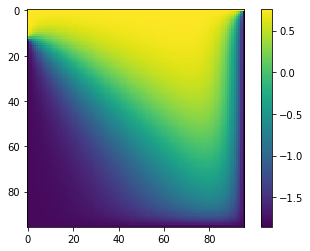

In [23]:
#snapshots = np.transpose(np.genfromtxt('drive/MyDrive/snapshots.csv', delimiter=','))
snapshots_ae = np.transpose(np.genfromtxt('drive/MyDrive/snapshots_ae_ad_di.csv', delimiter=','))
#snap_min = snapshots_ae.min()
#snap_max = snapshots_ae.max()
snap_mean = np.mean(snapshots_ae)
snap_std  = np.std(snapshots_ae)
snapshots_ae = (snapshots_ae - snap_mean) / snap_std
#snapshots_ae = (snapshots_ae - snap_min) / (snap_max - snap_min)

print(snapshots_ae.max())
print(snapshots_ae.min())
print(snapshots_ae.shape)

snapshots_ae = np.reshape(snapshots_ae, [80, 96, 96, 1])
print(snapshots_ae.shape)

check = 10
from pylab import *
figure(1)
imshow(snapshots_ae[check,:,:,0], interpolation='nearest')
plt.colorbar()
print(snapshots_ae[check,:,:,0].max())
print(snapshots_ae[check,:,:,0].min())